<a href="https://colab.research.google.com/github/frogbysachs/LASA-Data-Science/blob/main/Copy_of_Unit6ExercisesSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unit 6 Exercises: Is my model good?

#### Over and Under fitting, Model Visualization, and Model/Variable Selection Concepts

These exercises are meant to get you to think about the model and variable selection process, and consider how we determine if a model is "good".

In [ ]:
import numpy as np
import pandas as pd
import arviz as az
import pymc as pm
import matplotlib.pyplot as plt

In [ ]:
!pip install bambi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.2/109.2 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 3.9 MB/s eta 0:00:00


In [ ]:
import bambi as bmb

**Task1**:

Does elpd_loo mean anything if we only have one model?

No; we don't care about the magnitude of the number that gets spit out for a single model using elpd_loo, only how that number compares with the one spit out for other models. On its own it means nothing.

**Task2**:

Describe overfitting, in the context of this course

Overfitting is what happens when we take too many variables into account, so much so that the model gets confused and you wind up with a worse prediction.

**Task3**:

How do we mitigate overfitting?

We can use weak priors to help our model weed out which information is and isn't important.

**Task4**:

How do we mitigate underfitting?

Avoiding underfitting can be mostly taken care of by picking a good model based on the number that elpd_loo spits out for us when we compare multiple potential models.

**Task5**:

Why would we want more than one predictor in a model?

In many (even most) real life situations, there are simply multiple factors that affect the thing you're trying to predict. For example, while there is a relationship between temperature and bikes rented, there is also a relationship between the time of day and bikes rented- so it makes sense to include both predictors.

**Task6**:

Can we have too many predictors? How would we now?

Yes, it's possible to have too many predictors. We can anecdotally see that this is true when we compare two models (one with an extra predictor added and one that is otherwise identical but doesn't have that predictor), and the one without the predictor seems to give a better prediction of our outcomes. However another way to do this is to compare elpd_loo values for different models and see which one the computer thinks is better.

**Task7**:

What is variable selection, and how does it work?

Variable selection is the process of considering which predictors we're going to use for a given model that we're creating. We want to draw a causal diagram that includes all of the data columns that we have, and drawing relationship arrows between different potential variables, as well as the information we're trying to predict.

**Task8**:

Describe the differences and similarities between the following three models: linear regression with two predictors, one of which is a categorical variable:

- adding the variables in the model, as is standard.
- using that categorical variable as a hierarchy upon the other predictor variable.
- adding the variables, plus the categorical variable's interaction with the other variable.

These three ways of forming linear regression models will often yield similar elpd_loo values.

However, if you're just doing the standard way of adding variables into the model, the plot predictions will give that all of your lines have the same slope, whereas slopes will vary if you're using hierarchies or interactions with your variables.

Between hierarchies and interactions, the output graphs can look extremely similar, especially if there is both an interaction between multiple of your variables, and one variable can mean something different depending on the other.

Finally, the simplest difference between hierarchies and interactions is that hyperpriors are an important element of hierarchical models.

**Task9**:

How do we visualize multiple linear regression models? Can we visualize the entire model, all at once?

They really can just go on top of each other. If we're using two predictors and one outcome, we can plot the predictors against each other and use the slope of that graph as a way to understand our outcome. However sometimes it's necessary to make multiple graphs to see how slopes / HDIs / other trends change with one changing variable within a finite range.

**Task10**:

Compare the following linear models that all use the basketball data to predict field goal percentage:

- predictors free throw percentage and position (with position as a categorical predictor)
- predictors free throw percentage and position (with position as a hierarchy)
- predictors free throw percentage and position (with position interacting with frew throw percentage)
- predictors free throw percentage, position, 3 point attempts, and interactions between all three predictors
- predictors free throw percentage, position, 3 point attempts, with an interaction between 3 point attempts and postion.

using ```az.compare()``` and ```az.plot_compare()```, or an equivalent method using LOO (elpd_loo).

You may use the following two code blocks to load and clean the data.

In [ ]:
#have to drop incomplete rows, so that bambi will run
bb = pd.read_csv(
    'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/refs/heads/main/Data/basketball2324.csv').dropna()

In [ ]:
#only look at players who played more than 600 minutes
#which is 20 min per game, for 30 games
bb = bb.query('MP > 600')
#remove players who never missed a free throw
bb = bb.query('`FT%` != 1.0')
#filter out the combo positions. This will make it easier to read the graphs
bb = bb.query("Pos in ['C','PF','SF','SG','PG']")
#gets rid of the annoying '%' sign
bb.rename(columns={"FT%":"FTp","FG%":"FGp"}, inplace=True)

FTp and POS as a categorical:

In [ ]:
#define the model
bb_FTpPOS = bmb.Model("`FGp` ~ `FTp` + Pos", data=bb)
#fit the model
idata_bb_FTpPOS = bb_FTpPOS.fit(idata_kwargs={'log_likelihood': True})

Output()

Output()

FTp and POS as a hierarchy:

In [ ]:
#define the model, but as a hierarchy
bb_FTpPOS_h = bmb.Model("`FGp` ~ (`FTp`|Pos)", data=bb)
#create the model
idata_bb_FTpPOS_h = bb_FTpPOS_h.fit(idata_kwargs={'log_likelihood': True})


Output()

Output()

ERROR:pymc.stats.convergence:There were 81 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


FTp and POS interacting:

In [ ]:
#define the model; bb_inter stands for baskeball interaction
bb_FTpPOS_inter = bmb.Model("`FGp` ~ `FTp` + Pos + `FTp`:Pos", data=bb)
#create the model
idata_bb_FTpPOS_inter = bb_FTpPOS_inter.fit(idata_kwargs={'log_likelihood': True})

Output()

Output()

FTp, POS, and 3PA all interacting:

In [ ]:
#dictors free throw percentage, position, 3 point attempts, and interactions between all three predictors
bb_FTpPOS3PA_inter = bmb.Model("`FGp` ~ `FTp` + Pos + `3PA` + `FTp`:Pos + `FTp`:`3PA` + Pos:`3PA`", data=bb)
idata_bb_FTpPOS3PA_inter = bb_FTpPOS3PA_inter.fit(idata_kwargs={'log_likelihood': True})

Output()

Output()

FTp, POS, and 3PA with an interaction between POS and 3PA:

In [ ]:
#dictors free throw percentage, position, 3 point attempts, and interactions between all three predictors
bb_FTpPOS3PA_inter23 = bmb.Model("`FGp` ~ `FTp` + Pos + `3PA` + Pos:`3PA`", data=bb)
idata_bb_FTpPOS3PA_inter23 = bb_FTpPOS3PA_inter23.fit(idata_kwargs={'log_likelihood': True})

Output()

Output()

In [ ]:
#Last:
cmp_bb_bmb = az.compare( {"idata_bb_FTpPOS":idata_bb_FTpPOS,"idata_bb_FTpPOS_h":idata_bb_FTpPOS_h,"idata_bb_FTpPOS_inter":idata_bb_FTpPOS_inter,"idata_bb_FTpPOS3PA_inter":idata_bb_FTpPOS3PA_inter,"idata_bb_FTpPOS3PA_inter23":idata_bb_FTpPOS3PA_inter23} )
cmp_bb_bmb

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
idata_bb_FTpPOS3PA_inter23,0,530.269517,12.189382,0.000000,5.876887e-01,15.733180,0.000000,False,log
idata_bb_FTpPOS3PA_inter,1,529.205937,18.975419,1.063580,4.123113e-01,15.020207,3.626158,False,log
idata_bb_FTpPOS_inter,2,509.064578,14.157360,21.204939,0.000000e+00,16.880522,7.759521,False,log
idata_bb_FTpPOS_h,3,508.531436,13.698971,21.738081,0.000000e+00,16.953156,7.176640,False,log
idata_bb_FTpPOS,4,507.207343,8.457154,23.062174,2.220446e-15,16.124618,6.814143,False,log


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

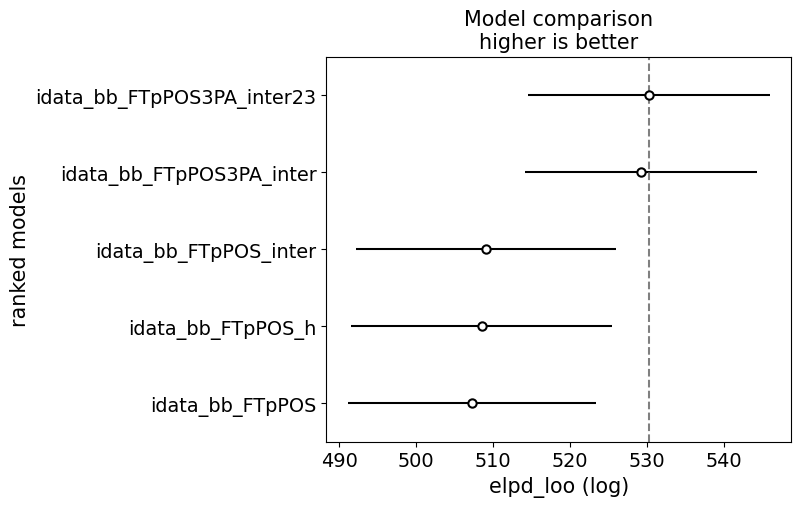

In [ ]:
az.plot_compare(cmp_bb_bmb)

**Task11**:

Which model is "better" according to this metric?

Why do you think that is?

The model that includes the most predictors, but only accounts for interactions between some of them, does the best by a small margin. FT%, Position, and # of 3-point attempts are all good predictors of FG%, but the model is slightly less overfitted when we don't tell it about any interactions between FT% and Position, or between FT% and 3PA.

This is because while those interactions may exist, they're weak enough correlations that it doesn't help at all to add them to our model.